This notebook presents the preliminary analysis of machine learning models to make predictions of taxi demand in Manhattan based on weather and trip related features. This notebook includes data merging, feature engineering, and preliminary aggregation of hourly pickup and drop-off counts. To analyse the appropriateness of several models to this task, a few of them, including Random Forest and XGBoost, were briefly tested. In the final version of the project none of the models created in this notebook were used. This notebook was more of a trial run to gain an idea of how to relate features and model them and an attempt to understand feature relationships.

In [1]:
# Importing.
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, median_absolute_error, explained_variance_score
import numpy as np
import lightgbm as lgb
import xgboost as xgb
from sklearn.linear_model import Ridge
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from scipy.stats import randint

In [2]:
# Loading the cleaned dataset.
df = pd.read_parquet("manhattan_taxi_2024_clean.parquet")

# Examining it.
print(df.shape)
df.head()

(33690778, 24)


,tpep_pickup_datetime,tpep_dropoff_datetime,PULocationID,DOLocationID,passenger_count,trip_distance,pickup_hour,pickup_dayofweek,is_weekend,trip_duration_min,...,pickup_minute,is_holiday,pickup_hour_ts,zone_hourly_pickups,dropoff_hour_ts,zone_hourly_dropoffs,zone_hourly_total_activity,day_part,is_peak_hour,season
0,2024-01-01 00:57:55,2024-01-01 01:17:43,186,79,1.0,1.72,0,0,False,19.80,...,57,True,2024-01-01,88,2024-01-01 01:00:00,281,369,night,False,winter
1,2024-01-01 00:03:00,2024-01-01 00:09:36,140,236,1.0,1.80,0,0,False,6.60,...,3,True,2024-01-01,91,2024-01-01 00:00:00,169,260,night,False,winter
2,2024-01-01 00:17:06,2024-01-01 00:35:01,236,79,1.0,4.70,0,0,False,17.92,...,17,True,2024-01-01,160,2024-01-01 00:00:00,183,343,night,False,winter
3,2024-01-01 00:36:38,2024-01-01 00:44:56,79,211,1.0,1.40,0,0,False,8.30,...,36,True,2024-01-01,328,2024-01-01 00:00:00,35,363,night,False,winter
4,2024-01-01 00:46:51,2024-01-01 00:52:57,211,148,1.0,0.80,0,0,False,6.10,...,46,True,2024-01-01,49,2024-01-01 00:00:00,60,109,night,False,winter


In [3]:
# Loading weather data.
weather_df = pd.read_csv("weather_2024_cleaned.csv")

# Ensuring datetime formats.
weather_df['date'] = pd.to_datetime(weather_df['date'])
df['pickup_date'] = pd.to_datetime(df['pickup_date'])

# Merging data.
merged_df = pd.merge(
    df,
    weather_df,
    how='left',
    left_on=['pickup_date', 'pickup_hour'],
    right_on=['date', 'hour']
)

# Dropping duplicate keys.
merged_df.drop(['date', 'hour'], axis=1, inplace=True)

# Examining merged df.
merged_df.head()

,tpep_pickup_datetime,tpep_dropoff_datetime,PULocationID,DOLocationID,passenger_count,trip_distance,pickup_hour,pickup_dayofweek,is_weekend,trip_duration_min,...,zone_hourly_dropoffs,zone_hourly_total_activity,day_part,is_peak_hour,season,temp,humidity,wind_speed,feels_like,weather_main
0,2024-01-01 00:57:55,2024-01-01 01:17:43,186,79,1.0,1.72,0,0,False,19.80,...,281,369,night,False,winter,5.75,59.0,4.47,2.53,Rain
1,2024-01-01 00:03:00,2024-01-01 00:09:36,140,236,1.0,1.80,0,0,False,6.60,...,169,260,night,False,winter,5.75,59.0,4.47,2.53,Rain
2,2024-01-01 00:17:06,2024-01-01 00:35:01,236,79,1.0,4.70,0,0,False,17.92,...,183,343,night,False,winter,5.75,59.0,4.47,2.53,Rain
3,2024-01-01 00:36:38,2024-01-01 00:44:56,79,211,1.0,1.40,0,0,False,8.30,...,35,363,night,False,winter,5.75,59.0,4.47,2.53,Rain
4,2024-01-01 00:46:51,2024-01-01 00:52:57,211,148,1.0,0.80,0,0,False,6.10,...,60,109,night,False,winter,5.75,59.0,4.47,2.53,Rain


In [4]:
# Dropping readable time that was added previously.
merged_df.drop(columns=[
    'trip_duration_readable'
], inplace=True)

In [5]:
# Defining which features to keep and how to summarise them.
grouped = merged_df.groupby(['pickup_date', 'pickup_hour', 'PULocationID']).agg({
    'trip_distance': 'mean',
    'trip_duration_min': 'mean',
    'temp': 'mean',
    'humidity': 'mean',
    'wind_speed': 'mean',
    'feels_like': 'mean',
    'is_weekend': 'max',
    'is_holiday': 'max',
    'is_peak_hour': 'max',
    'weather_main': lambda x: x.mode().iloc[0] if not x.mode().empty else None # Picking most frequent one during the hour to summarise.
}).reset_index()

In [6]:
# Adding pickup/dropoff counts.
pickup_counts = merged_df.groupby(['pickup_date', 'pickup_hour', 'PULocationID']).size().reset_index(name='zone_hourly_pickups')
dropoff_counts = merged_df.groupby(['pickup_date', 'pickup_hour', 'DOLocationID']).size().reset_index(name='zone_hourly_dropoffs')
dropoff_counts.rename(columns={'DOLocationID': 'PULocationID'}, inplace=True)


In [7]:
# Merging them into the grouped dataset.
grouped = pd.merge(grouped, pickup_counts, on=['pickup_date', 'pickup_hour', 'PULocationID'], how='left')
grouped = pd.merge(grouped, dropoff_counts, on=['pickup_date', 'pickup_hour', 'PULocationID'], how='left')

In [8]:
# Printing missing counts beforehand.
print("Missing pickups:", grouped['zone_hourly_pickups'].isna().sum())
print("Missing dropoffs:", grouped['zone_hourly_dropoffs'].isna().sum())

# Filling NaNs with 0 for counts.   
grouped['zone_hourly_pickups'] = grouped['zone_hourly_pickups'].fillna(0).astype(int)
grouped['zone_hourly_dropoffs'] = grouped['zone_hourly_dropoffs'].fillna(0).astype(int)

Missing pickups: 0
Missing dropoffs: 6320


In [9]:
# Rounding to two decimals.
grouped = grouped.round(2)

# Saving as new csv.
grouped.to_csv("zone_hourly_summary.csv", index=False)

In [10]:
# Loading new dataset.
df = pd.read_csv("zone_hourly_summary.csv")

In [11]:
# Getting unique weather conditions.
unique_conditions = df['weather_main'].dropna().unique()

# Creating bool features for each condition,
for condition in unique_conditions:
    df[f'weather_{condition}'] = df['weather_main'] == condition

# Dropping original column.
df.drop(columns='weather_main', inplace=True)

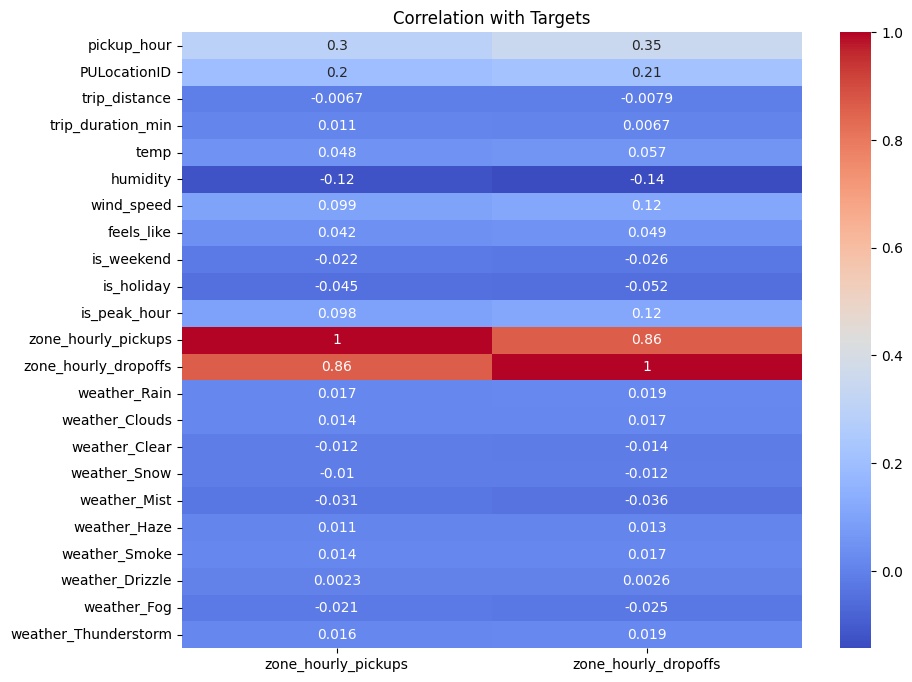

In [12]:
# Initial examination of correlation between features and target features.
corr = df.corr(numeric_only=True)
plt.figure(figsize=(10, 8))
sns.heatmap(corr[['zone_hourly_pickups', 'zone_hourly_dropoffs']], annot=True, cmap='coolwarm')
plt.title("Correlation with Targets")
plt.show()

In [13]:
# Preparing features and targets.
target_columns = ['zone_hourly_pickups', 'zone_hourly_dropoffs']
feature_columns = df.select_dtypes(include=['number']).columns.difference(target_columns)
X = df[feature_columns]
y_pickups = df['zone_hourly_pickups']
y_dropoffs = df['zone_hourly_dropoffs']

In [14]:
# Splitting data.
X_train_pu, X_test_pu, y_train_pu, y_test_pu = train_test_split(X, y_pickups, test_size=0.2, random_state=42)
X_train_do, X_test_do, y_train_do, y_test_do = train_test_split(X, y_dropoffs, test_size=0.2, random_state=42)

In [15]:
# Training models.
pu_model = RandomForestRegressor(n_estimators=100, random_state=42)
do_model = RandomForestRegressor(n_estimators=100, random_state=42)
pu_model.fit(X_train_pu, y_train_pu)
do_model.fit(X_train_do, y_train_do)

,n_estimators,100
,criterion,'squared_error'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,1.0
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [16]:
# Evaluating models.
def print_metrics(y_true, preds, label):
    print(f"{label} Model:")
    print("MAE:", mean_absolute_error(y_true, preds))
    print("MSE:", mean_squared_error(y_true, preds))
    print("RMSE:", np.sqrt(mean_squared_error(y_true, preds)))
    print("Median AE:", median_absolute_error(y_true, preds))
    print("R2:", r2_score(y_true, preds))
    print("Explained Variance:", explained_variance_score(y_true, preds))
    print("\n")

pu_preds = pu_model.predict(X_test_pu)
do_preds = do_model.predict(X_test_do)

print_metrics(y_test_pu, pu_preds, "Pickups")
print_metrics(y_test_do, do_preds, "Dropoffs")

Pickups Model:
MAE: 14.777784097748889
MSE: 714.8059372707756
RMSE: 26.73585490069049
Median AE: 7.0
R2: 0.9005432846444658
Explained Variance: 0.9006032075540145


Dropoffs Model:
MAE: 14.586708900124393
MSE: 558.5863924190442
RMSE: 23.63443234814503
Median AE: 8.190000000000001
R2: 0.8954806768674457
Explained Variance: 0.8955153303613879




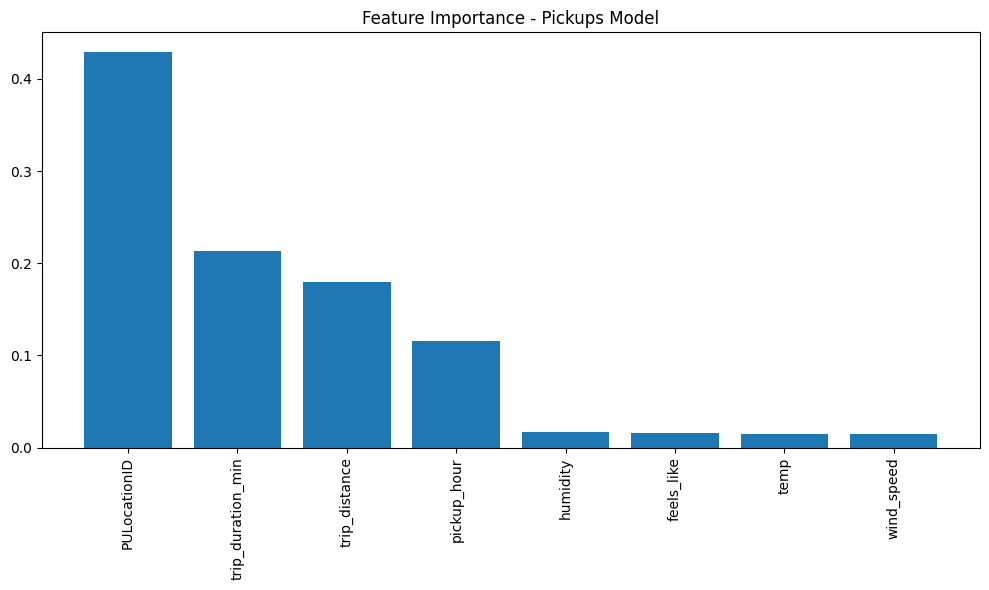

In [17]:
# For pickups model
importances_pu = pu_model.feature_importances_
indices_pu = np.argsort(importances_pu)[::-1]
features_pu = X.columns[indices_pu]

plt.figure(figsize=(10,6))
plt.bar(range(len(importances_pu)), importances_pu[indices_pu])
plt.xticks(range(len(importances_pu)), features_pu, rotation=90)
plt.title("Feature Importance - Pickups Model")
plt.tight_layout()
plt.show()

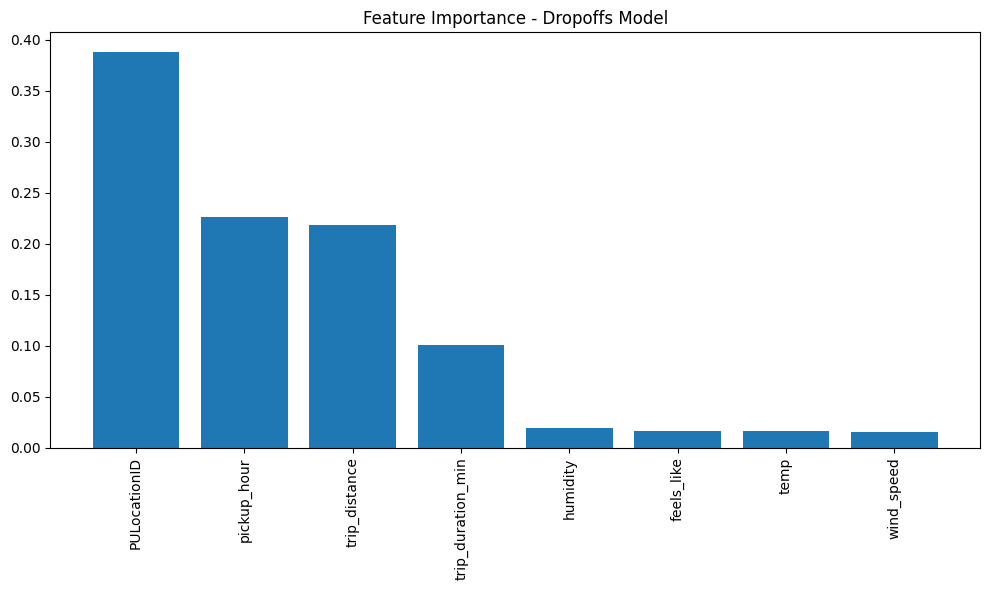

In [18]:
# For dropoffs model
importances_do = do_model.feature_importances_
indices_do = np.argsort(importances_do)[::-1]
features_do = X.columns[indices_do]

plt.figure(figsize=(10,6))
plt.bar(range(len(importances_do)), importances_do[indices_do])
plt.xticks(range(len(importances_do)), features_do, rotation=90)
plt.title("Feature Importance - Dropoffs Model")
plt.tight_layout()
plt.show()

In [19]:
# Pickups model.
lgbm_pu = lgb.LGBMRegressor(random_state=42)
lgbm_pu.fit(X_train_pu, y_train_pu)
pu_preds_lgbm = lgbm_pu.predict(X_test_pu)

print("LightGBM Pickups Model:")
print("MAE:", mean_absolute_error(y_test_pu, pu_preds_lgbm))
print("MSE:", mean_squared_error(y_test_pu, pu_preds_lgbm))
print("RMSE:", np.sqrt(mean_squared_error(y_test_pu, pu_preds_lgbm)))
print("Median AE:", median_absolute_error(y_test_pu, pu_preds_lgbm))
print("R2:", r2_score(y_test_pu, pu_preds_lgbm))
print("Explained Variance:", explained_variance_score(y_test_pu, pu_preds_lgbm))

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005561 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1269
[LightGBM] [Info] Number of data points in the train set: 398734, number of used features: 8
[LightGBM] [Info] Start training from score 67.620052
LightGBM Pickups Model:
MAE: 19.891519159484258
MSE: 1055.5773040382305
RMSE: 32.48964918305876
Median AE: 11.36185841028746
R2: 0.8531290158776011
Explained Variance: 0.8531308788958046


In [20]:
# Dropoffs model.
lgbm_do = lgb.LGBMRegressor(random_state=42)
lgbm_do.fit(X_train_do, y_train_do)
do_preds_lgbm = lgbm_do.predict(X_test_do)

print("LightGBM Dropoffs Model:")
print("MAE:", mean_absolute_error(y_test_do, do_preds_lgbm))
print("MSE:", mean_squared_error(y_test_do, do_preds_lgbm))
print("RMSE:", np.sqrt(mean_squared_error(y_test_do, do_preds_lgbm)))
print("Median AE:", median_absolute_error(y_test_do, do_preds_lgbm))
print("R2:", r2_score(y_test_do, do_preds_lgbm))
print("Explained Variance:", explained_variance_score(y_test_do, do_preds_lgbm))


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006596 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1269
[LightGBM] [Info] Number of data points in the train set: 398734, number of used features: 8
[LightGBM] [Info] Start training from score 67.241810
LightGBM Dropoffs Model:
MAE: 18.680864625826825
MSE: 785.1281848529959
RMSE: 28.020138915662
Median AE: 12.175056138936451
R2: 0.853091540419114
Explained Variance: 0.8530918535308464


In [21]:
# Pickups model.
xgb_pu = xgb.XGBRegressor(random_state=42)
xgb_pu.fit(X_train_pu, y_train_pu)
pu_preds_xgb = xgb_pu.predict(X_test_pu)

print("XGBoost Pickups Model:")
print("MAE:", mean_absolute_error(y_test_pu, pu_preds_xgb))
print("MSE:", mean_squared_error(y_test_pu, pu_preds_xgb))
print("RMSE:", np.sqrt(mean_squared_error(y_test_pu, pu_preds_xgb)))
print("Median AE:", median_absolute_error(y_test_pu, pu_preds_xgb))
print("R2:", r2_score(y_test_pu, pu_preds_xgb))
print("Explained Variance:", explained_variance_score(y_test_pu, pu_preds_xgb))

XGBoost Pickups Model:
MAE: 17.874486923217773
MSE: 888.4497680664062
RMSE: 29.806874510193218
Median AE: 10.025215148925781
R2: 0.8763828277587891
Explained Variance: 0.8763886094093323


In [22]:
# Dropoffs model.
xgb_do = xgb.XGBRegressor(random_state=42)
xgb_do.fit(X_train_do, y_train_do)
do_preds_xgb = xgb_do.predict(X_test_do)

print("XGBoost Dropoffs Model:")
print("MAE:", mean_absolute_error(y_test_do, do_preds_xgb))
print("MSE:", mean_squared_error(y_test_do, do_preds_xgb))
print("RMSE:", np.sqrt(mean_squared_error(y_test_do, do_preds_xgb)))
print("Median AE:", median_absolute_error(y_test_do, do_preds_xgb))
print("R2:", r2_score(y_test_do, do_preds_xgb))
print("Explained Variance:", explained_variance_score(y_test_do, do_preds_xgb))

XGBoost Dropoffs Model:
MAE: 16.49797821044922
MSE: 630.2117309570312
RMSE: 25.104018223324953
Median AE: 10.502233505249023
R2: 0.8820785880088806
Explained Variance: 0.8820787668228149


In [23]:
# Pickups model.
ridge_pu = Ridge()
ridge_pu.fit(X_train_pu, y_train_pu)
pu_preds_ridge = ridge_pu.predict(X_test_pu)

print("Ridge Pickups Model:")
print("MAE:", mean_absolute_error(y_test_pu, pu_preds_ridge))
print("MSE:", mean_squared_error(y_test_pu, pu_preds_ridge))
print("RMSE:", np.sqrt(mean_squared_error(y_test_pu, pu_preds_ridge)))
print("Median AE:", median_absolute_error(y_test_pu, pu_preds_ridge))
print("R2:", r2_score(y_test_pu, pu_preds_ridge))
print("Explained Variance:", explained_variance_score(y_test_pu, pu_preds_ridge))

Ridge Pickups Model:
MAE: 54.998423443048594
MSE: 6210.729851759372
RMSE: 78.80818391359728
Median AE: 41.683183299017635
R2: 0.13585106277235548
Explained Variance: 0.13585114750786886


In [24]:
# Dropoffs model.
ridge_do = Ridge()
ridge_do.fit(X_train_do, y_train_do)
do_preds_ridge = ridge_do.predict(X_test_do)

print("Ridge Dropoffs Model:")
print("MAE:", mean_absolute_error(y_test_do, do_preds_ridge))
print("MSE:", mean_squared_error(y_test_do, do_preds_ridge))
print("RMSE:", np.sqrt(mean_squared_error(y_test_do, do_preds_ridge)))
print("Median AE:", median_absolute_error(y_test_do, do_preds_ridge))
print("R2:", r2_score(y_test_do, do_preds_ridge))
print("Explained Variance:", explained_variance_score(y_test_do, do_preds_ridge))

Ridge Dropoffs Model:
MAE: 47.067021169471175
MSE: 4387.0191480434905
RMSE: 66.23457668048835
Median AE: 35.23707778060104
R2: 0.1791273862985927
Explained Variance: 0.17913227771704143


In [25]:
# Ensuring pickup_date is datetime.
df['pickup_date'] = pd.to_datetime(df['pickup_date'])

# Adding day_of_week (0=Monday, 6=Sunday).
df['day_of_week'] = df['pickup_date'].dt.dayofweek

# Checking new feature.
print(df[['pickup_date', 'day_of_week']].head())

  pickup_date  day_of_week
0  2024-01-01            0
1  2024-01-01            0
2  2024-01-01            0
3  2024-01-01            0
4  2024-01-01            0


In [26]:
# Adding a column that combines pickups and dropoffs.
df["zone_hourly_activity"] = df["zone_hourly_pickups"] + df["zone_hourly_dropoffs"]

In [27]:
# Adding centroid lat/lon, shape area, and shape length for each zone.
zones_df = pd.read_csv("manhattan_taxi_zones.csv")

# Checking available columns.
print(zones_df.columns)

# Merging relevant columns into the main DataFrame using PULocationID.
df = df.merge(
    zones_df[["OBJECTID", "centroid_lat", "centroid_lon", "Shape_Area", "Shape_Leng"]],
    left_on="PULocationID",
    right_on="OBJECTID",
    how="left"
)

# Dropping OBJECTID column since it's now redundant.
df.drop(columns=["OBJECTID"], inplace=True)

Index(['LocationID', 'OBJECTID', 'Shape_Area', 'Shape_Leng', 'borough',
       'centroid_lat', 'centroid_lon', 'geometry', 'zone'],
      dtype='object')


In [28]:
# Normalising historical pickup counts.
zone_hourly_stats = df.groupby(['pickup_hour', 'PULocationID'])['zone_hourly_activity'].mean().reset_index()
zone_hourly_stats.rename(columns={'zone_hourly_activity': 'historical_busyness'}, inplace=True)


min_b = zone_hourly_stats['historical_busyness'].min()
max_b = zone_hourly_stats['historical_busyness'].max()
zone_hourly_stats['normalised_busyness'] = (zone_hourly_stats['historical_busyness'] - min_b) / (max_b - min_b)

# Merging this value into dataset.
df = df.merge(zone_hourly_stats, on=['pickup_hour', 'PULocationID'], how='left')

In [29]:
# Checking locations as there seems to be some extra locations in the DataFrame.
sorted(df["PULocationID"].unique())

[4,
 12,
 13,
 24,
 41,
 42,
 43,
 45,
 48,
 50,
 68,
 74,
 75,
 79,
 87,
 88,
 90,
 100,
 105,
 107,
 113,
 114,
 116,
 120,
 125,
 127,
 128,
 137,
 140,
 141,
 142,
 143,
 144,
 148,
 151,
 152,
 153,
 158,
 161,
 162,
 163,
 164,
 166,
 170,
 186,
 202,
 209,
 211,
 224,
 229,
 230,
 231,
 232,
 233,
 234,
 236,
 237,
 238,
 239,
 243,
 244,
 246,
 249,
 261,
 262,
 263]

In [30]:
# Saving as new csv.
df.to_csv("zone_hourly_summary.csv", index=False)